In [1]:
import pathlib
import sys

sys.path.append("../")
sys.path.append("../utils/")

local_path = pathlib.Path().resolve()
local_path

WindowsPath('C:/Users/NielsOta/Code/StateSpace/nbs')

In [2]:
from typing import List, Optional, Dict, Tuple
from scipy.optimize import minimize
from collections import deque
from matplotlib import animation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import custom functions

In [3]:
from utils import _initiate_variables, _map_vector_to_matrices, _get_nan_positions, _remove_nan_tensor, _remove_inf_tensor, _get_bounds, read_target_from_path
from StateSpacingKalman import KalmanV1
from StateSpacingProtocols import KalmanProtocol, MathProtocol
from StateSpacingClasses import LinearGaussianModel_v2_numpy as LGM
from StateSpacingClasses import LLM_v1_numpy as LLM

# Local Level Using General Formulation

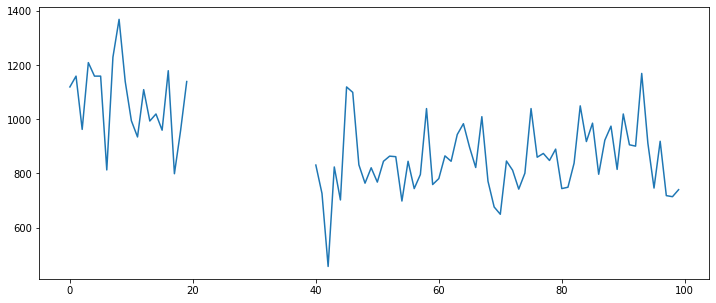

In [4]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
nile_path = data_dir / 'Nile.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(nile_path, dtype, header='infer')
y[:, :, 20:40] = np.nan

plt.figure(figsize=(12, 5))
plt.plot(np.squeeze(y))

assuming component at index 0 is main component of y


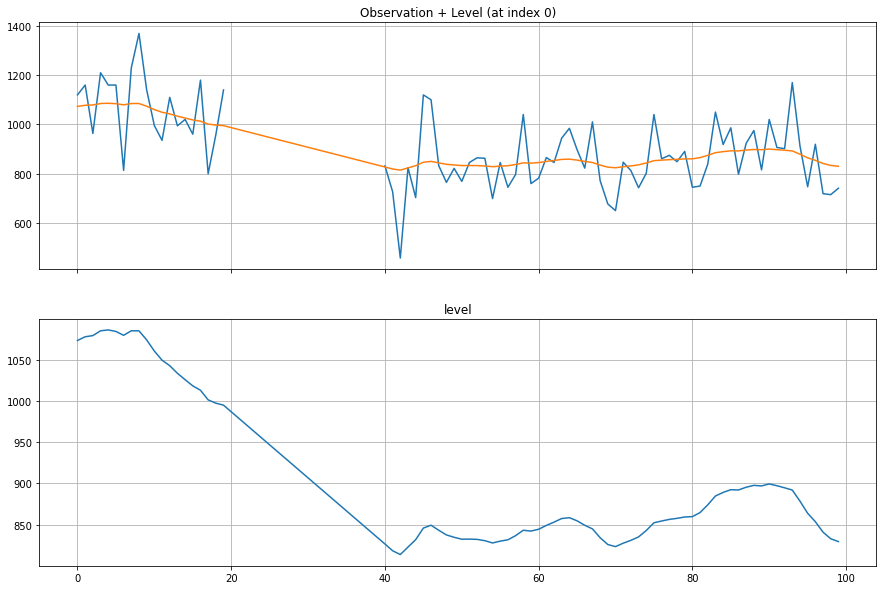

In [5]:
# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1]]).astype(dtype)
Z = np.array([[1]]).astype(dtype)
R = np.array([[1]]).astype(dtype)
Q = np.array([[1]]).astype(dtype)
H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_llm = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1:  {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level"}

llm = LGM(y, T, Z, R, Q, H, diffuse, dict_param_llm, filter_map)
llm.fit()
llm.plot_states()

# Local Linear Trend Using General Formulation

In [ ]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
llt_path = data_dir / 'llt.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(llt_path, dtype)
y[:, :, 60:80] = np.nan

#key point: clear trend, but trend changing
plt.figure(figsize=(12, 5))
plt.plot(np.squeeze(y))

In [ ]:
# Declare State Matrices Local linear Trend Model -> use [[]] for extra dimension
T = np.array([[1, 1], [0, 1]]).astype(dtype)
Z = np.array([[1, 0]]).astype(dtype)
R = np.array([[1, 0], [0, 1]]).astype(dtype)
Q = np.array([[1, 0], [0, 1]]).astype(dtype)
H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_llt = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1: {"matrix" : "Q", "index": (1, 1, 0), "constant": True, "bounds": (0.1, None)},
    2: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level", 1: "trend"}

llt = LGM(y, T, Z, R, Q, H, diffuse, dict_param_llt, filter_map)
llt.fit()
llt.plot_states()

# Local Linear Trend w/ Seasonal Component

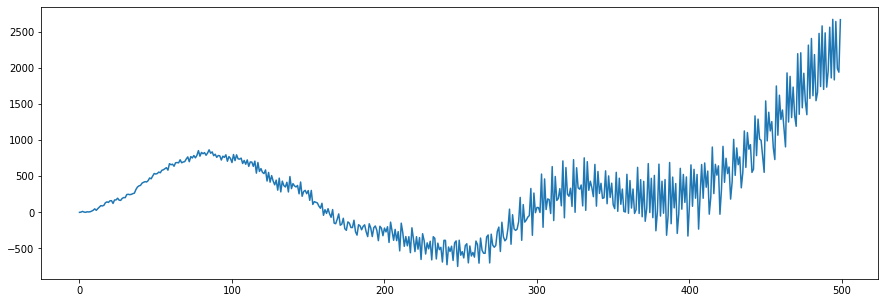

In [6]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
llt_path = data_dir / 'llts.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(llt_path, dtype)
#y[:, :, 400:500] = np.nan

plt.figure(figsize=(15, 5))
plt.plot(np.squeeze(y))

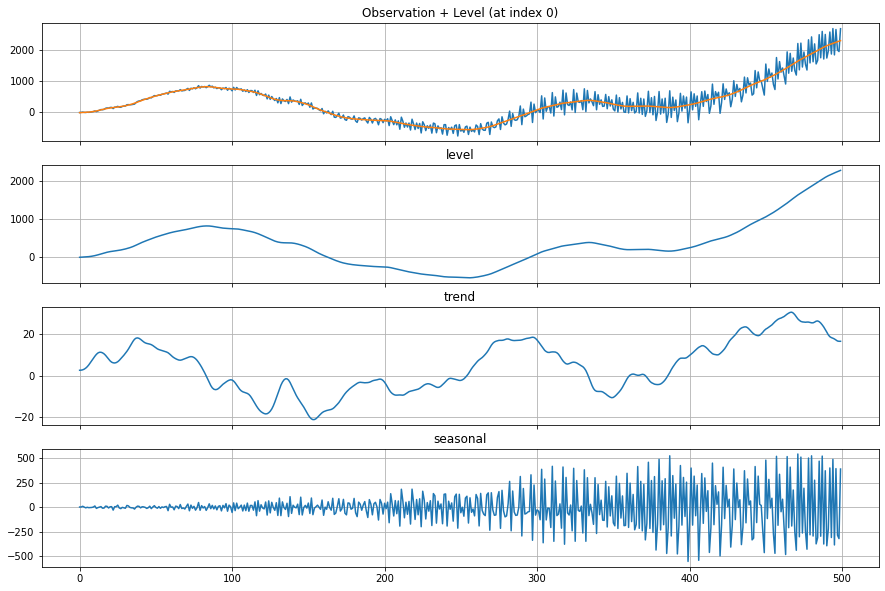

In [7]:
# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1, 1, 0, 0, 0, 0, 0, 0], 
              [0, 1, 0, 0, 0, 0, 0, 0], 
              [0, 0, -1, -1, -1, -1, -1, -1], 
              [0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0], 
              [0, 0, 0, 0, 0, 1, 0, 0], 
              [0, 0, 0, 0, 0, 0, 1, 0]]).astype(dtype)

Z = np.array([[1, 0, 1, 0, 0, 0, 0, 0]]).astype(dtype)

R = np.array([[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1], 
              [0, 0, 0], 
              [0, 0, 0], 
              [0, 0, 0], 
              [0, 0, 0], 
              [0, 0, 0]]).astype(dtype)

Q = np.array([[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1]]).astype(dtype)

H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_llts = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1: {"matrix" : "Q", "index": (1, 1, 0), "constant": True, "bounds": (0.1, None)},
    2: {"matrix" : "Q", "index": (2, 2, 0), "constant": True, "bounds": (0.1, None)},
    3: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level", 1: "trend", 2: "seasonal"}

llts = LGM(y, T, Z, R, Q, H, diffuse, dict_param_llts, filter_map)
llts.fit()
llts.plot_states(signal_components=['level'])

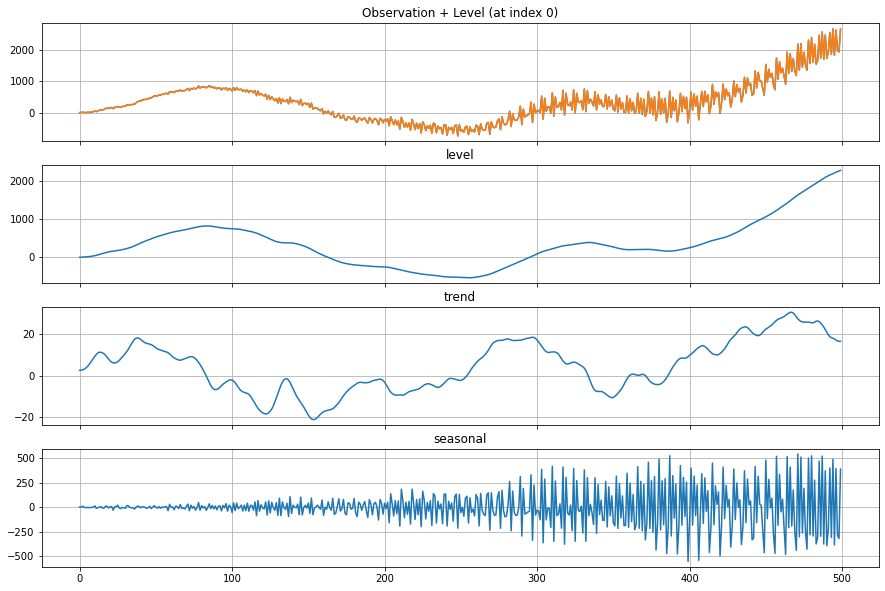

In [8]:
llts.plot_states(signal_components=['level', 'seasonal'])

# Local Linear Trend w/ Seasonal Component and Exogenous Regressor

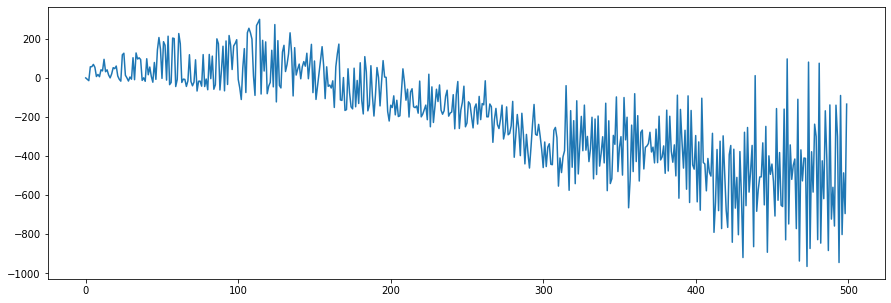

In [9]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
lltsx_path = data_dir / 'lltsX.txt'
regressor_path = data_dir / 'regressor.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(lltsx_path, dtype)
X = read_target_from_path(regressor_path, dtype)
# y[:, :, 400:500] = np.nan

plt.figure(figsize=(15, 5))
plt.plot(np.squeeze(y))

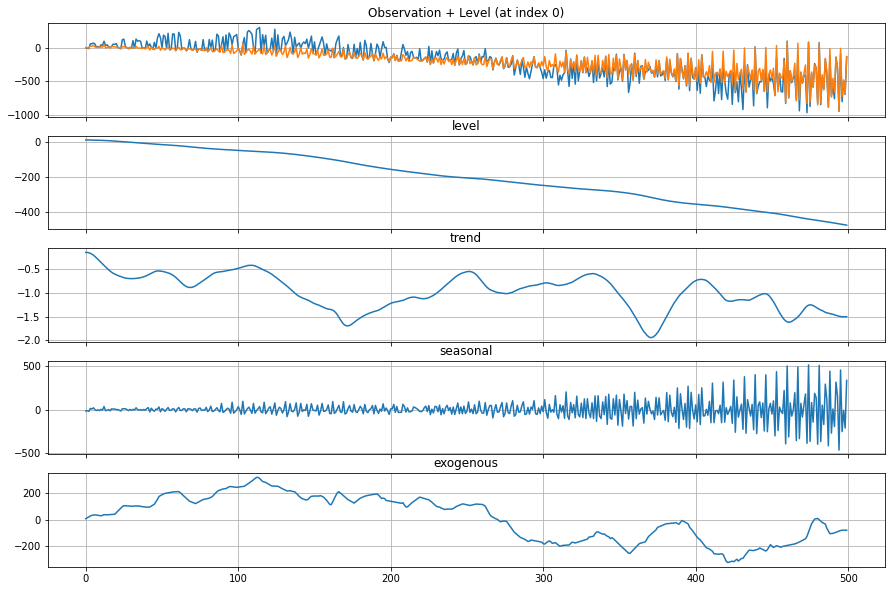

In [10]:
# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0], 
              [0, 1, 0, 0, 0, 0, 0, 0, 0], 
              [0, 0, -1, -1, -1, -1, -1, -1, 0], 
              [0, 0, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0, 0], 
              [0, 0, 0, 0, 0, 1, 0, 0, 0], 
              [0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1]]).astype(dtype)

Z = np.array([[1, 0, 1, 0, 0, 0, 0, 0, 1]]).astype(dtype)
Z = np.repeat(Z[:, :, None], 500, axis=2)
Z[0, 8, :] = X 

R = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 1, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0],
              [0, 0, 0, 1]]).astype(dtype)

Q = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 1, 0],
              [0, 0, 0, 1]]).astype(dtype)

H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_lltsX = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1: {"matrix" : "Q", "index": (1, 1, 0), "constant": True, "bounds": (0.1, None)},
    2: {"matrix" : "Q", "index": (2, 2, 0), "constant": True, "bounds": (0.1, None)},
    3: {"matrix" : "Q", "index": (3, 3, 0), "constant": True, "bounds": (0.1, None)},
    4: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level", 1: "trend", 2: "seasonal", 8: "exogenous"}

lltsX = LGM(y, T, Z, R, Q, H, diffuse, dict_param_lltsX, filter_map)
lltsX.fit()
lltsX.plot_states(signal_components=['level', 'seasonal'])

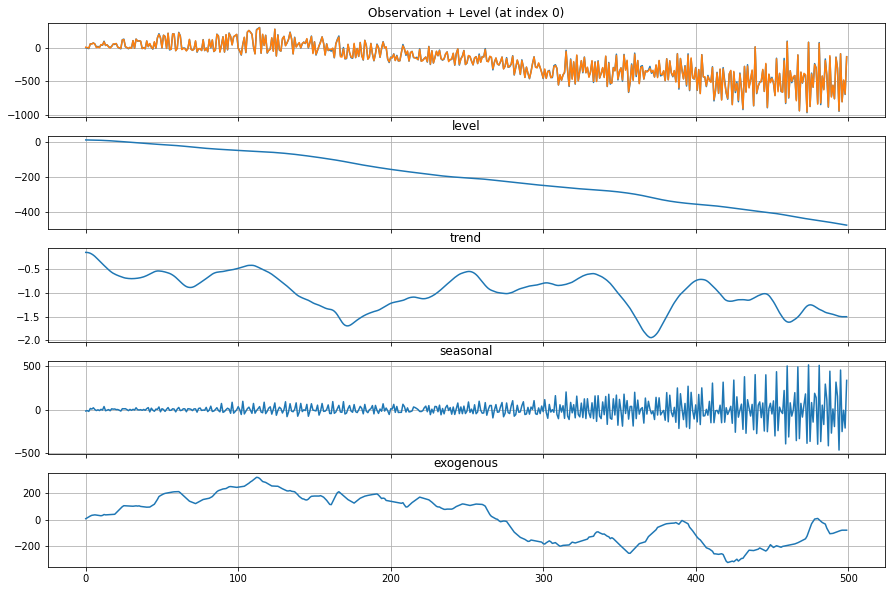

In [11]:
lltsX.plot_states(signal_components=['level', 'seasonal', 'exogenous'])

# Regression (with missing observations)

Slope set to 100 during data generating process

How to make slope parameter time varying? Interpretable as changing effect of exogenous variable. 

In [ ]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
y_path = data_dir / 'standard_regressionY.txt'
x_path = data_dir / 'standard_regressionX.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(y_path, dtype)
X = read_target_from_path(x_path, dtype)
# y[:, :, 400:500] = np.nan

# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1]]).astype(dtype)
Z = np.array([[1]]).astype(dtype)
Z = np.repeat(Z[:, :, None], 500, axis=2)
Z[0, 0, :] = X 

R = np.array([[1]]).astype(dtype)
Q = np.array([[0]]).astype(dtype)
H = np.array([[1]]).astype(dtype)

diffuse = True

dict_param_llts = {
    0: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
}

filter_map = {0: "exogenous"}

lltsX = LGM(y, T, Z, R, Q, H, diffuse, dict_param_llts, filter_map)
lltsX.fit()
lltsX.plot_states(signal_components=["exogenous"])